In [1]:
import glob
import numpy as np

In [2]:
frds = glob.glob('output/ccx/*/*.frd')
dats = glob.glob('output/ccx/*/*.dat')

In [3]:
# dats = dats[1:]
# frds = frds[1:]

In [4]:
from djccx.read_dat import read_dat
from djccx.frd.readfrd import readfrd

In [5]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934
A_s = 0.283 # mm^2

r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  0,
    "density"   : 5,
}
params_ccx = {
    "epsilon" : 0.1,
    "x_fixed" : True
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [6]:
from FEM_traccion.CreateLines.CreateLines import CreateLines

lines = CreateLines({
        "r": 2.5,
        "Nx_sq": 1,
        "Ny_sq": 1,
        "type":  'sin' # 'circle' or 'sin'
    })

In [7]:
frds

['output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd',
 'output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd']

In [8]:
design = [ lines["designs"][idesign]["ly_0"]
         for idesign in ["SX","SY","X","Y"] ]

In [9]:
from gmshtools.grid_section import grid_section
from matplotlib import pyplot as plt

In [10]:
%matplotlib ipympl

In [11]:
frds

['output/ccx\\SX\\main.frd',
 'output/ccx\\SY\\main.frd',
 'output/ccx\\X\\main.frd',
 'output/ccx\\Y\\main.frd']

In [55]:
ifrd = readfrd(frds[0])
idesign = design[0]


In [56]:
data = ifrd["data"]

In [57]:
ymin = 0.5 
ymax = 9.5
xmin = 0.5
xmax = 9.5

data = data[data["x"] > xmin]
data = data[data["x"] < xmax]
data = data[data["y"] > ymin]
data = data[data["y"] < ymax]


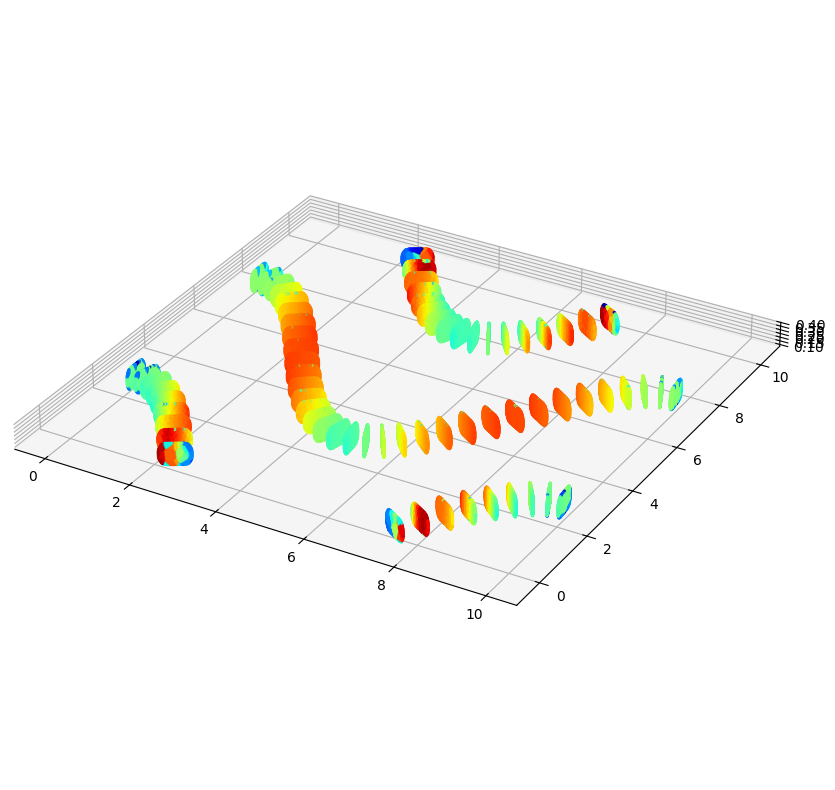

In [66]:
# neartest neighbor interpolation
from scipy.interpolate import NearestNDInterpolator


x = data["x"]
y = data["y"]
z = data["z"]
P1 = data["P1"]

fcn = NearestNDInterpolator((x,y,z),P1)

d = params_composite["d"]
r = params_composite["r"]

fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')


colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink']

P1_mean_trajs = []
for jj,jtrajs in enumerate(idesign):

    jtraj_diff = np.diff(jtrajs,axis=0)

    P1_mean = []
    for j in range(0,len(jtraj_diff),600):

        vec_z =  jtraj_diff[j]
        vec_z = vec_z/np.linalg.norm(vec_z)
        vec_x = np.cross(vec_z, [0,0,1])
        vec_x = vec_x/np.linalg.norm(vec_x)

        X,Y,Z = grid_section(jtrajs[j][0],
                            jtrajs[j][1],
                            jtrajs[j][2],
                            vec_z,
                            vec_x,
                            0.8*d,
                            0.8*r,
                            rho=150)
        Z = Z + params_composite["h"]/2
        P1 = fcn(X,Y,Z)
        P1
        # ax.plot(X,Y,Z, alpha=0.5, color=colors[jj])
        ax.scatter(X,Y,Z, c=P1, alpha=0.5, marker='o', s=1, cmap='jet',vmin=0, vmax=500)
        P1_mean.append({
            "x": np.mean(X),
            "y": np.mean(Y),
            "z": np.mean(Z),
            "P1": np.mean(P1),
        })
    P1_mean_trajs.append(P1_mean)
# aspect ratio 
plt.gca().set_box_aspect([1,1,0.05])  # aspect ratio is 1:1:1
# # off ticks 
# plt.xticks([])
# plt.yticks([])


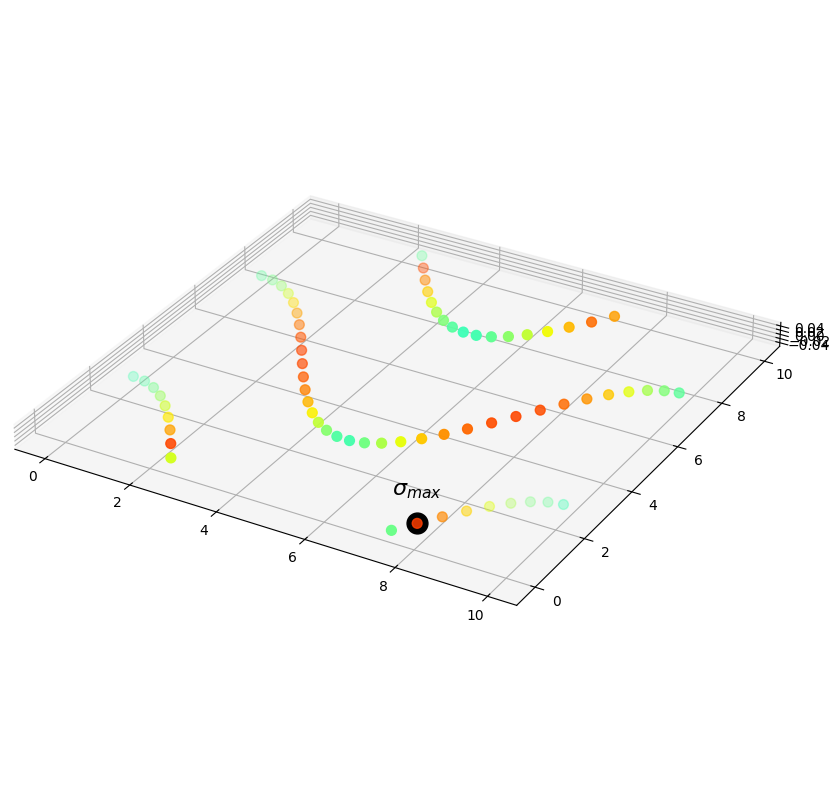

In [135]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')

maximuns = []
for iP1_traj in P1_mean_trajs:
    x = [ii["x"] for ii in iP1_traj]
    y = [ii["y"] for ii in iP1_traj]
    z = [ii["z"] for ii in iP1_traj]
    P1 = [ii["P1"] for ii in iP1_traj]

    idx_P1_max_line = np.argmax(P1)
    xmax_line = x[idx_P1_max_line]
    ymax_line = y[idx_P1_max_line]
    zmax_line = z[idx_P1_max_line]
    P1max_line = P1[idx_P1_max_line]

    maximuns.append({
        "x": xmax_line,
        "y": ymax_line,
        "z": zmax_line,
        "P1": P1max_line,
    })

    plt.scatter(x,y,200, c=P1, marker='.',cmap='jet',vmin=0, vmax=500)

id_P1_max = np.argmax([ii["P1"] for ii in maximuns])
xmax = maximuns[id_P1_max]["x"]
ymax = maximuns[id_P1_max]["y"]
zmax = maximuns[id_P1_max]["z"]
P1max = maximuns[id_P1_max]["P1"]

plt.plot(xmax,ymax,0, marker='o', color='black', markersize=15, label="P1 max")
# text box with arrow and border line
ax.text(xmax, ymax, 0.1, r'$\sigma_{max}$', fontsize=16, color='black', ha='center', va='bottom')
plt.gca().set_box_aspect([1,1,0.05])  # aspect ratio is 1:1:1


In [136]:
maximuns

[{'x': np.float64(2.1004200840168035),
  'y': np.float64(0.621085560749249),
  'z': np.float64(0.2375),
  'P1': np.float64(416.3327447136814)},
 {'x': np.float64(7.800060012002401),
  'y': np.float64(0.468545883042969),
  'z': np.float64(0.2375),
  'P1': np.float64(421.7772414287649)},
 {'x': np.float64(2.8000600120024006),
  'y': np.float64(9.531454116957033),
  'z': np.float64(0.2375),
  'P1': np.float64(413.6693405134713)},
 {'x': np.float64(2.400480096019203),
  'y': np.float64(5.156223646738557),
  'z': np.float64(0.2375),
  'P1': np.float64(416.8087985344555)}]

In [ ]:
iP1_traj


In [ ]:
x

[np.float64(-6.116012255046436e-22),
 np.float64(0.30006001200240046),
 np.float64(0.6001200240048008),
 np.float64(0.9001800360072014),
 np.float64(1.2002400480096018),
 np.float64(1.5003000600120024),
 np.float64(1.8003600720144028),
 np.float64(2.1004200840168035),
 np.float64(2.400480096019203)]

In [16]:
ifrd = readfrd(frds[0])


In [17]:
from scipy.interpolate import NearestNDInterpolator


def compute_P1_max(data,idesign,params_composite):

    x = data["x"]
    y = data["y"]
    z = data["z"]
    P1 = data["P1"]

    fcn = NearestNDInterpolator((x,y,z),P1)

    d = params_composite["d"]
    r = params_composite["r"]

    P1_mu_list = []
    for jj,jtrajs in enumerate(idesign):

        jtraj_diff = np.diff(jtrajs,axis=0)

        for j in range(0,len(jtraj_diff),600):

            vec_z =  jtraj_diff[j]
            vec_z = vec_z/np.linalg.norm(vec_z)
            vec_x = np.cross(vec_z, [0,0,1])
            vec_x = vec_x/np.linalg.norm(vec_x)

            X,Y,Z = grid_section(jtrajs[j][0],
                                jtrajs[j][1],
                                jtrajs[j][2],
                                vec_z,
                                vec_x,
                                0.8*d,
                                0.8*r,
                                rho=150)
            Z = Z + params_composite["h"]/2
            P1 = fcn(X,Y,Z)
            P1_mu = np.mean(P1)
            P1_mu_list.append(P1_mu)

        # ============================

    P1_max = np.max(P1_mu_list)

    return P1_max

In [18]:
from djccx.inp.inp import inp

In [19]:
frds
inp_paths = [ i.replace(".frd",".inp") for i in frds]

In [20]:
t_l/4

0.11875

In [21]:
# neartest neighbor interpolation

P1_time_design = []
Sapl_list_design = []
P1_time_matrix_design = []
for ii in range(4):

    idesign = design[ii]
    ifrd = readfrd(frds[ii])
    inp_f = inp(inp_paths[ii])

    #
    BOX_PLUS = inp_f.select("BOX_PLUS","elset")
    df = BOX_PLUS.GetUniqueNodes(inp_f)
    indx_frd = df.index.values

    P1_time   = []
    Sapl_list = []
    P1_fibres_time = []

    for data in ifrd["data_blocks"]:

        # =============================
        # compute Sigma Aplicado
        # ============================
        
        ancho = params_composite["z0"]*0.5 +params_composite["h"]
        largo = 10 
        A = ancho*largo
        Sapl = np.sum(data["F2"]*(data["y"] > data["y"].mean()))/A
        Sapl_list.append(Sapl)

        # =============================
        # compute P1_max of fibres
        # ============================
        data_cp = data.copy()
        data_cp = data_cp[data_cp["x"] > xmin]
        data_cp = data_cp[data_cp["x"] < xmax]
        data_cp = data_cp[data_cp["y"] > ymin]
        data_cp = data_cp[data_cp["y"] < ymax]

        P1_max = compute_P1_max(data_cp,idesign,params_composite)
        
        P1_time.append(P1_max)

        # ============================
        # Compute P1_max of matrix
        # ============================
        data_cp = data.copy()

        nodes_matrix = data_cp.loc[indx_frd]

        data_cp = data_cp[data_cp["x"] > xmin]
        data_cp = data_cp[data_cp["x"] < xmax]
        data_cp = data_cp[data_cp["y"] > ymin]
        data_cp = data_cp[data_cp["y"] < ymax]
        
        id_max = np.argmax(data_cp["P1"])

        P1_max = data_cp["P1"].iloc[id_max]
        x_max = data_cp["x"].iloc[id_max]
        y_max = data_cp["y"].iloc[id_max]
        z_max = data_cp["z"].iloc[id_max]

        dist = np.sqrt((x_max - nodes_matrix["x"])**2 + \
                       (y_max - nodes_matrix["y"])**2 + \
                       (z_max - nodes_matrix["z"])**2)
        
        nodes_matrix = nodes_matrix[dist < 0.15]

        print("number of nodes in matrix",len(nodes_matrix))
        # mean P1  
        # P1_max = np.mean(nodes_matrix["P1"])

        P1_fibres_time.append(P1_max)
        # ============================

    P1_time_matrix_design.append(P1_fibres_time)
    P1_time_design.append(P1_time)
    Sapl_list_design.append(Sapl_list)

number of nodes in matrix 75
number of nodes in matrix 26
number of nodes in matrix 26
number of nodes in matrix 78
number of nodes in matrix 76
number of nodes in matrix 76
number of nodes in matrix 58
number of nodes in matrix 48
number of nodes in matrix 48
number of nodes in matrix 58
number of nodes in matrix 52
number of nodes in matrix 52


In [22]:
%matplotlib inline

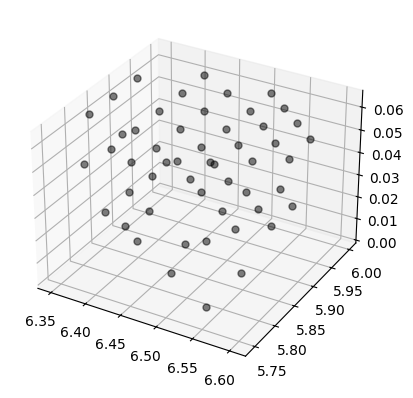

In [53]:
# plot scatter nodes_matrix 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.plot(nodes_matrix["x"],
         nodes_matrix["y"],
         nodes_matrix["z"],marker='o', alpha=0.5, color='k', 
         markersize=5,linestyle='None')

plt.show()


In [24]:
Sapl_list_design[0]

[np.float64(0.0),
 np.float64(56.43239871956173),
 np.float64(112.86480552634521)]

In [25]:
P1_time_matrix_design[0]

[np.float64(0.0),
 np.float64(241.6716157821846),
 np.float64(483.34406543297536)]

In [26]:
P1_time_design[0]

[np.float64(0.0),
 np.float64(210.88860544558725),
 np.float64(421.7772414287649)]

In [27]:
%matplotlib inline

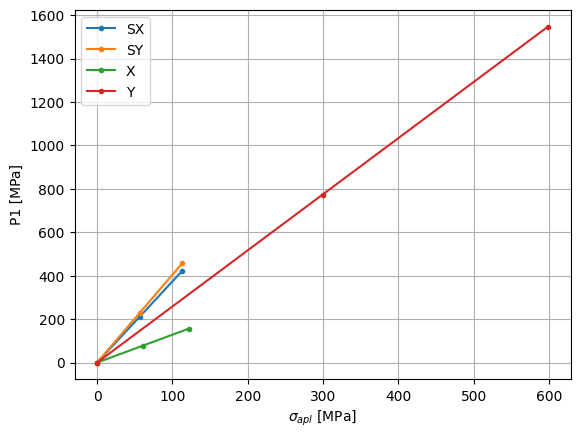

In [28]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
for ii in range(4):
    plt.plot(Sapl_list_design[ii],P1_time_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$\sigma_{apl}$ [MPa]")
plt.ylabel("P1 [MPa]")
plt.legend()
plt.grid()  

In [29]:
ratio_fibra = [ P1_time_design[ii][-1]/Sapl_list_design[ii][-1] for ii in range(4)]
ratio_matrix = [ P1_time_matrix_design[ii][-1]/Sapl_list_design[ii][-1] for ii in range(4)]
ratio = {
    "SX": {"fibra": ratio_fibra[0], "matrix": ratio_matrix[0]},
    "SY": {"fibra": ratio_fibra[1], "matrix": ratio_matrix[1]},
    "X": {"fibra": ratio_fibra[2], "matrix": ratio_matrix[2]},
    "Y": {"fibra": ratio_fibra[3], "matrix": ratio_matrix[3]}
}

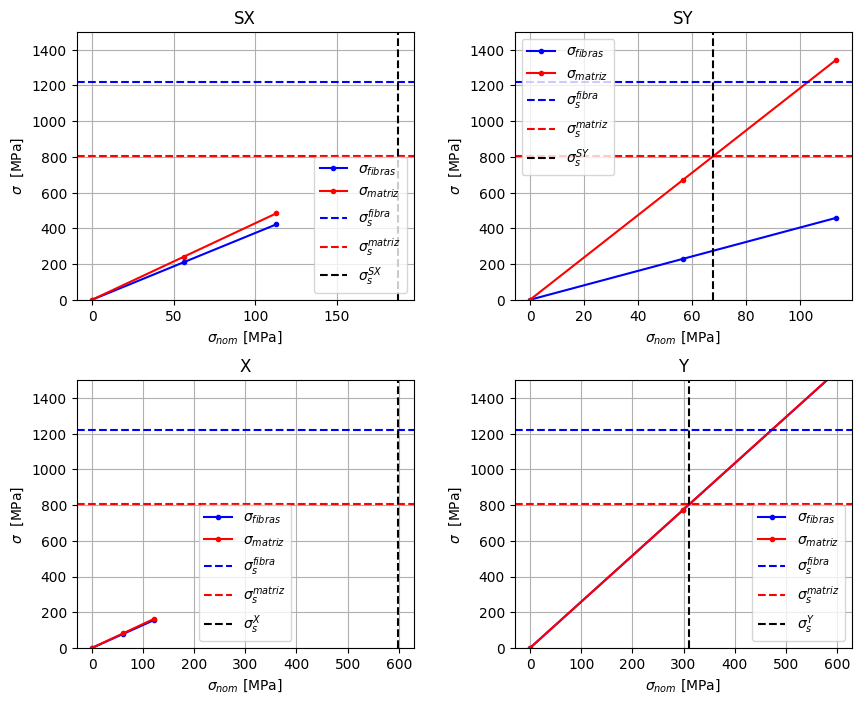

In [52]:
labels = ["SX","SY","X","Y"]
fig = plt.figure(figsize=(10, 8))
#subplot 
plt.subplots_adjust(wspace=0.3, 
                    hspace=0.3)

Sfibre = 1219.69588 
Smatrix = 804.16161 



colors = ["b","r"]

Srotura = {}
for ii in range(4):

    # subplot 
    plt.subplot(2,2,ii+1)
    plt.plot(Sapl_list_design[ii],P1_time_design[ii],'.-', label=r"$\sigma_{fibras}$",color='b')
    plt.plot(Sapl_list_design[ii],P1_time_matrix_design[ii],'.-', label= r"$\sigma_{matriz}$",color='r')
    
    plt.axhline(y=Sfibre, linestyle='--', label=r"$\sigma_s^{fibra}$",color='b')
    plt.axhline(y=Smatrix, linestyle='--', label=r"$\sigma_s^{matriz}$",color='r')

    Sposibles  = [Sfibre/ratio[labels[ii]]["fibra"],Smatrix/ratio[labels[ii]]["matrix"]]
    idx_S = np.argmin(Sposibles)
    S = Sposibles[idx_S]

    Srotura[labels[ii]] = S

    label = r"$\sigma_s^{CC}$"  
    label = label.replace("CC",labels[ii])
    plt.axvline(x=S, linestyle='--', 
                label=label,
                color="k")

    # [0,0] -> [ S,]
    plt.xlabel(r"$\sigma_{nom}$ [MPa]")
    plt.ylabel(r"$\sigma$  [MPa]")
    plt.title(labels[ii])
    plt.legend()
    plt.grid()  
    plt.ylim(0,1500)


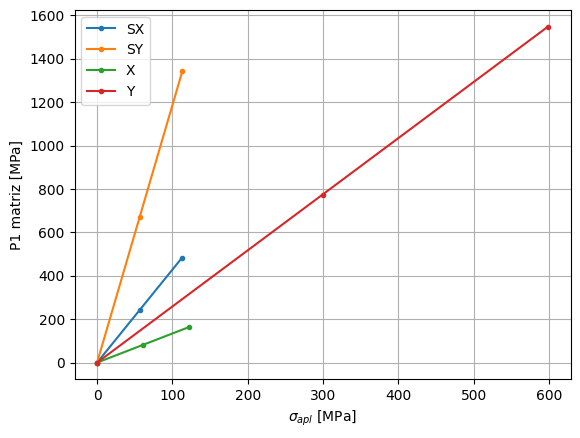

In [31]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
for ii in range(4):
    plt.plot(Sapl_list_design[ii],P1_time_matrix_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$\sigma_{apl}$ [MPa]")
plt.ylabel("P1 matriz [MPa]")
plt.legend()
plt.grid()  

In [32]:
Srotura

{'SX': np.float64(187.77833476262765),
 'SY': np.float64(67.82212993131522),
 'X': np.float64(599.253951636008),
 'Y': np.float64(311.05426888201464)}

In [33]:

ratio

{'SX': {'fibra': np.float64(3.7370129639776195),
  'matrix': np.float64(4.282504746974928)},
 'SY': {'fibra': np.float64(4.046305929413829),
  'matrix': np.float64(11.85692060709963)},
 'X': {'fibra': np.float64(1.2844055304827087),
  'matrix': np.float64(1.341937934334148)},
 'Y': {'fibra': np.float64(2.5841400155862795),
  'matrix': np.float64(2.585277523726977)}}

In [36]:
import pandas as pd 
pd.DataFrame(ratio)

,SX,SY,X,Y
fibra,3.737013,4.046306,1.284406,2.584140
matrix,4.282505,11.856921,1.341938,2.585278


In [34]:
ratio

{'SX': {'fibra': np.float64(3.7370129639776195),
  'matrix': np.float64(4.282504746974928)},
 'SY': {'fibra': np.float64(4.046305929413829),
  'matrix': np.float64(11.85692060709963)},
 'X': {'fibra': np.float64(1.2844055304827087),
  'matrix': np.float64(1.341937934334148)},
 'Y': {'fibra': np.float64(2.5841400155862795),
  'matrix': np.float64(2.585277523726977)}}

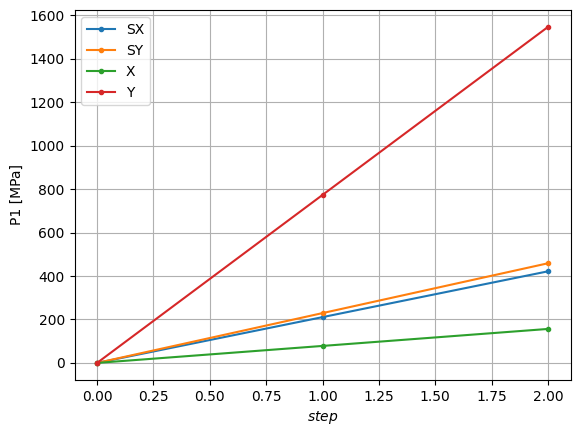

In [35]:
fig = plt.figure()
labels = ["SX","SY","X","Y"]
for ii in range(4):
    plt.plot(P1_time_design[ii],'.-', label=labels[ii])
plt.xlabel(r"$step$")
plt.ylabel("P1 [MPa]")
plt.legend()
plt.grid()  